In [14]:
# EV車両データのクラスタリング分析
# hashvinごとにDBSCANとHDBSCANを実行し、結果を比較

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import hdbscan
import folium
import warnings
warnings.filterwarnings('ignore')

# 日本語フォントの設定
plt.rcParams['font.family'] = 'Yu Gothic'
plt.rcParams['axes.unicode_minus'] = False

print("必要なライブラリのインポート完了")

必要なライブラリのインポート完了


=== テストデータの生成 ===
生成されたテストデータ:
  車両数: 5
  総データポイント数: 1000
  各車両のデータポイント数: 200
  緯度範囲: 33.4996 ~ 43.1404
  経度範囲: 130.3135 ~ 141.4478
  inactive_duration_min範囲: 0.2 ~ 480.0分


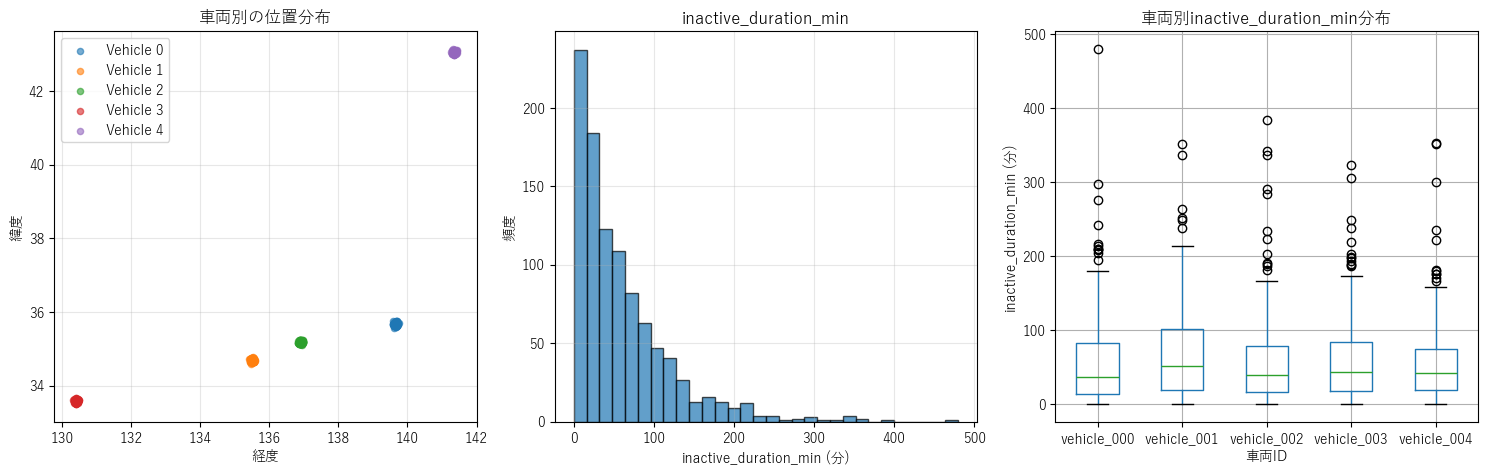


テストデータの基本統計:
       inactive_start_lat  inactive_start_lon  inactive_duration_min
count         1000.000000         1000.000000            1000.000000
mean            36.439233          136.765301              60.820273
std              3.382977            3.784166              62.123286
min             33.499615          130.313488               0.193407
25%             34.674154          135.485986              17.896199
50%             35.183237          136.907910              42.257905
75%             35.691270          139.675821              82.986818
max             43.140424          141.447798             480.000000


In [15]:
# テストデータの生成
print("=== テストデータの生成 ===")

np.random.seed(42)  # 再現性のため

# テストデータの生成
n_vehicles = 5  # 車両数
n_points_per_vehicle = 200  # 各車両のデータポイント数

test_data = []

for vehicle_id in range(n_vehicles):
    # 各車両の拠点位置（東京、大阪、名古屋、福岡、札幌周辺）
    base_locations = [
        (35.6762, 139.6503),  # 東京
        (34.6937, 135.5023),  # 大阪
        (35.1815, 136.9066),  # 名古屋
        (33.5902, 130.4017),  # 福岡
        (43.0618, 141.3545),  # 札幌
    ]
    
    base_lat, base_lon = base_locations[vehicle_id]
    
    # 各車両の拠点周辺にデータポイントを生成
    for i in range(n_points_per_vehicle):
        # 緯度経度のばらつき（約5km程度）
        lat_std = 0.03  # 約3.3km
        lon_std = 0.03  # 約3.3km
        
        lat = np.random.normal(base_lat, lat_std)
        lon = np.random.normal(base_lon, lon_std)
        
        # inactive_duration_min（分単位、0-480分の範囲）
        inactive_duration_min = np.random.exponential(60)  # 平均60分の指数分布
        inactive_duration_min = min(inactive_duration_min, 480)  # 最大480分
        
        test_data.append({
            'hashvin': f'vehicle_{vehicle_id:03d}',
            'inactive_start_lat': lat,
            'inactive_start_lon': lon,
            'inactive_duration_min': inactive_duration_min
        })

# DataFrameに変換
df_test = pd.DataFrame(test_data)

print(f"生成されたテストデータ:")
print(f"  車両数: {df_test['hashvin'].nunique()}")
print(f"  総データポイント数: {len(df_test)}")
print(f"  各車両のデータポイント数: {n_points_per_vehicle}")
print(f"  緯度範囲: {df_test['inactive_start_lat'].min():.4f} ~ {df_test['inactive_start_lat'].max():.4f}")
print(f"  経度範囲: {df_test['inactive_start_lon'].min():.4f} ~ {df_test['inactive_start_lon'].max():.4f}")
print(f"  inactive_duration_min範囲: {df_test['inactive_duration_min'].min():.1f} ~ {df_test['inactive_duration_min'].max():.1f}分")

# データの可視化
plt.figure(figsize=(15, 5))

# 車両別の位置分布
plt.subplot(1, 3, 1)
for vehicle_id in range(n_vehicles):
    vehicle_data = df_test[df_test['hashvin'] == f'vehicle_{vehicle_id:03d}']
    plt.scatter(vehicle_data['inactive_start_lon'], vehicle_data['inactive_start_lat'], 
               alpha=0.6, s=20, label=f'Vehicle {vehicle_id}')
plt.title('車両別の位置分布')
plt.xlabel('経度')
plt.ylabel('緯度')
plt.legend()
plt.grid(True, alpha=0.3)

# inactive_duration_min分布
plt.subplot(1, 3, 2)
plt.hist(df_test['inactive_duration_min'], bins=30, alpha=0.7, edgecolor='black')
plt.title('inactive_duration_min')
plt.xlabel('inactive_duration_min (分)')
plt.ylabel('頻度')
plt.grid(True, alpha=0.3)

# 車両別inactive_duration_min分布
plt.subplot(1, 3, 3)
df_test.boxplot(column='inactive_duration_min', by='hashvin', ax=plt.gca())
plt.title('車両別inactive_duration_min分布')
plt.suptitle('')  # サブタイトルを削除
plt.xlabel('車両ID')
plt.ylabel('inactive_duration_min (分)')

plt.tight_layout()
plt.show()

# テストデータの基本統計
print("\nテストデータの基本統計:")
print(df_test.describe())

### データの前処理とスケーリング

In [21]:
# 車両別の地図生成
print("=== 車両別の地図生成 ===")

# クラスター別の色リスト
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 
          'beige', 'darkgreen', 'darkblue', 'darkpurple', 'pink', 'lightblue', 
          'lightgreen', 'gray', 'black', 'lightgray']

for vehicle_hashvin, results in vehicle_clustering_results.items():
    print(f"\n{vehicle_hashvin} の地図を生成中...")
    
    vehicle_data = results['data']
    dbscan_labels = results['dbscan_labels']
    hdbscan_labels = results['hdbscan_labels']
    
    # 車両データの中心座標（緯度経度を使用）
    center_lat = vehicle_data['inactive_start_lat'].mean()
    center_lon = vehicle_data['inactive_start_lon'].mean()
    
    # 地図の作成
    m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles='OpenStreetMap')
    
    # レイヤーグループを作成
    dbscan_group = folium.FeatureGroup(name='DBSCAN結果')
    hdbscan_group = folium.FeatureGroup(name='HDBSCAN結果')
    dbscan_connections = folium.FeatureGroup(name='DBSCAN接続線')
    hdbscan_connections = folium.FeatureGroup(name='HDBSCAN接続線')
    
    # DBSCAN結果を地図上にプロット
    for i, (idx, row) in enumerate(vehicle_data.iterrows()):
        cluster_id = dbscan_labels[i]
        if cluster_id == -1:
            # ノイズ点は小さな黒い点で表示
            folium.CircleMarker(
                location=[row['inactive_start_lat'], row['inactive_start_lon']],
                radius=3,
                color='black',
                fill=True,
                fillColor='black',
                fillOpacity=0.7,
                popup=f'DBSCAN ノイズ点<br>inactive_duration_min: {row["inactive_duration_min"]:.1f}分',
                tooltip=f'DBSCAN ノイズ'
            ).add_to(dbscan_group)
        else:
            # クラスター点は色分けして表示
            color = colors[cluster_id % len(colors)]
            folium.CircleMarker(
                location=[row['inactive_start_lat'], row['inactive_start_lon']],
                radius=4,
                color=color,
                fill=True,
                fillColor=color,
                fillOpacity=0.7,
                popup=f'DBSCAN クラスター{cluster_id}<br>inactive_duration_min: {row["inactive_duration_min"]:.1f}分',
                tooltip=f'DBSCAN C{cluster_id}'
            ).add_to(dbscan_group)
    
    # HDBSCAN結果を地図上にプロット
    for i, (idx, row) in enumerate(vehicle_data.iterrows()):
        cluster_id = hdbscan_labels[i]
        # 位置を少しずらして重複を避ける
        lat_offset = 0.0005  # 約50m程度のオフセット
        lon_offset = 0.0005
        
        if cluster_id == -1:
            # ノイズ点は小さな灰色の点で表示
            folium.CircleMarker(
                location=[row['inactive_start_lat'] + lat_offset, row['inactive_start_lon'] + lon_offset],
                radius=3,
                color='gray',
                fill=True,
                fillColor='gray',
                fillOpacity=0.7,
                popup=f'HDBSCAN ノイズ点<br>inactive_duration_min: {row["inactive_duration_min"]:.1f}分',
                tooltip=f'HDBSCAN ノイズ'
            ).add_to(hdbscan_group)
        else:
            # クラスター点は色分けして表示（四角形で区別）
            color = colors[cluster_id % len(colors)]
            folium.RegularPolygonMarker(
                location=[row['inactive_start_lat'] + lat_offset, row['inactive_start_lon'] + lon_offset],
                number_of_sides=4,
                radius=4,
                color=color,
                fill=True,
                fillColor=color,
                fillOpacity=0.7,
                popup=f'HDBSCAN クラスター{cluster_id}<br>inactive_duration_min: {row["inactive_duration_min"]:.1f}分',
                tooltip=f'HDBSCAN C{cluster_id}'
            ).add_to(hdbscan_group)
    
    # クラスター中心を表示し、中心座標を保存
    dbscan_centers = {}
    hdbscan_centers = {}
    
    # DBSCANクラスター中心
    unique_dbscan_clusters = set(dbscan_labels)
    for cluster_id in unique_dbscan_clusters:
        if cluster_id != -1:
            # クラスターに属するポイントのマスクを作成
            cluster_mask = np.array(dbscan_labels) == cluster_id
            cluster_points = vehicle_data.iloc[cluster_mask]
            
            if len(cluster_points) > 0:
                center_lat = cluster_points['inactive_start_lat'].mean()
                center_lon = cluster_points['inactive_start_lon'].mean()
                
                # 中心座標を保存
                dbscan_centers[cluster_id] = (center_lat, center_lon)
                
                folium.Marker(
                    location=[center_lat, center_lon],
                    icon=folium.Icon(color='red', icon='star'),
                    popup=f'DBSCAN クラスター{cluster_id}中心<br>ポイント数: {len(cluster_points)}',
                    tooltip=f'DBSCAN C{cluster_id}中心'
                ).add_to(dbscan_group)
    
    # HDBSCANクラスター中心
    unique_hdbscan_clusters = set(hdbscan_labels)
    for cluster_id in unique_hdbscan_clusters:
        if cluster_id != -1:
            # クラスターに属するポイントのマスクを作成
            cluster_mask = np.array(hdbscan_labels) == cluster_id
            cluster_points = vehicle_data.iloc[cluster_mask]
            
            if len(cluster_points) > 0:
                center_lat = cluster_points['inactive_start_lat'].mean()
                center_lon = cluster_points['inactive_start_lon'].mean()
                
                # 中心座標を保存
                hdbscan_centers[cluster_id] = (center_lat + 0.0005, center_lon + 0.0005)
                
                folium.Marker(
                    location=[center_lat + 0.0005, center_lon + 0.0005],
                    icon=folium.Icon(color='blue', icon='certificate'),
                    popup=f'HDBSCAN クラスター{cluster_id}中心<br>ポイント数: {len(cluster_points)}',
                    tooltip=f'HDBSCAN C{cluster_id}中心'
                ).add_to(hdbscan_group)
    
    # DBSCANクラスター間の接続線を描画
    dbscan_cluster_ids = list(dbscan_centers.keys())
    for i in range(len(dbscan_cluster_ids)):
        for j in range(i + 1, len(dbscan_cluster_ids)):
            cluster1_id = dbscan_cluster_ids[i]
            cluster2_id = dbscan_cluster_ids[j]
            
            center1 = dbscan_centers[cluster1_id]
            center2 = dbscan_centers[cluster2_id]
            
            # クラスター間の距離を計算（度単位）
            distance_deg = np.sqrt((center1[0] - center2[0])**2 + (center1[1] - center2[1])**2)
            # キロメートル単位に変換（1度 ≈ 111km）
            distance_km = distance_deg * 111
            
            # 線の太さを距離に応じて調整（距離が近いほど太い線）
            weight = max(1, 6 - distance_deg * 1000)  # 距離に応じて1-6の太さ
            
            folium.PolyLine(
                locations=[center1, center2],
                color='red',
                weight=weight,
                opacity=0.7,
                popup=f'DBSCAN クラスター{cluster1_id} ↔ クラスター{cluster2_id}<br>距離: {distance_km:.1f}km',
                tooltip=f'DBSCAN C{cluster1_id} ↔ C{cluster2_id}'
            ).add_to(dbscan_connections)
    
    # HDBSCANクラスター間の接続線を描画
    hdbscan_cluster_ids = list(hdbscan_centers.keys())
    for i in range(len(hdbscan_cluster_ids)):
        for j in range(i + 1, len(hdbscan_cluster_ids)):
            cluster1_id = hdbscan_cluster_ids[i]
            cluster2_id = hdbscan_cluster_ids[j]
            
            center1 = hdbscan_centers[cluster1_id]
            center2 = hdbscan_centers[cluster2_id]
            
            # クラスター間の距離を計算（度単位）
            distance_deg = np.sqrt((center1[0] - center2[0])**2 + (center1[1] - center2[1])**2)
            # キロメートル単位に変換（1度 ≈ 111km）
            distance_km = distance_deg * 111
            
            # 線の太さを距離に応じて調整（距離が近いほど太い線）
            weight = max(1, 6 - distance_deg * 1000)  # 距離に応じて1-6の太さ
            
            folium.PolyLine(
                locations=[center1, center2],
                color='blue',
                weight=weight,
                opacity=0.7,
                popup=f'HDBSCAN クラスター{cluster1_id} ↔ クラスター{cluster2_id}<br>距離: {distance_km:.1f}km',
                tooltip=f'HDBSCAN C{cluster1_id} ↔ C{cluster2_id}'
            ).add_to(hdbscan_connections)
    
    # レイヤーを地図に追加
    dbscan_group.add_to(m)
    hdbscan_group.add_to(m)
    dbscan_connections.add_to(m)
    hdbscan_connections.add_to(m)
    
    # レイヤーコントロールを追加
    folium.LayerControl().add_to(m)
    
    # タイトルを追加
    title_html = f'''
    <h3 align="center" style="font-size:16px">
        {vehicle_hashvin} - クラスタリング結果比較
    </h3>
    '''
    m.get_root().html.add_child(folium.Element(title_html))
    
    # 凡例の追加
    legend_html = f'''
    <div style="position: fixed; 
                bottom: 50px; left: 50px; width: 280px; height: 350px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:12px; padding: 10px">
                <p><b>{vehicle_hashvin} クラスタリング結果</b></p>
                <p><b>DBSCAN:</b></p>
                <p>● 丸いマーカー（クラスター点）</p>
                <p>● 黒い点（ノイズ）</p>
                <p>⭐ 赤い星（クラスター中心）</p>
                <p>━━ 赤い線（クラスター間接続）</p>
                <br>
                <p><b>HDBSCAN:</b></p>
                <p>■ 四角いマーカー（クラスター点）</p>
                <p>■ 灰色の点（ノイズ）</p>
                <p>�� 青いアイコン（クラスター中心）</p>
                <p>━━ 青い線（クラスター間接続）</p>
                <br>
                <p><i>レイヤーコントロールで切り替え可能</i></p>
                <p><i>線の太さは距離に比例</i></p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    # 地図を保存
    filename = f'{vehicle_hashvin}_clustering_map.html'
    m.save(filename)
    print(f"地図を '{filename}' として保存しました")

print(f"\n全車両の地図生成完了: {len(vehicle_clustering_results)}車両分")

=== 車両別の地図生成 ===

vehicle_000 の地図を生成中...
地図を 'vehicle_000_clustering_map.html' として保存しました

vehicle_001 の地図を生成中...
地図を 'vehicle_001_clustering_map.html' として保存しました

vehicle_002 の地図を生成中...
地図を 'vehicle_002_clustering_map.html' として保存しました

vehicle_003 の地図を生成中...
地図を 'vehicle_003_clustering_map.html' として保存しました

vehicle_004 の地図を生成中...
地図を 'vehicle_004_clustering_map.html' として保存しました

全車両の地図生成完了: 5車両分


### 充電場所と放置場所の直線サンプル

In [47]:
def create_charging_parking_route_map(session_df,
                                     charging_inactive_summary_df,
                                     charging_summary_df=None,
                                     charging_cluster_id_col='charging_cluster_id',
                                     charging_lat_col='charging_lat', 
                                     charging_lon_col='charging_lon',
                                     parking_cluster_id_col='parking_cluster_id',
                                     parking_lat_col='parking_lat',
                                     parking_lon_col='parking_lon',
                                     charging_center_lat_col='charging_center_lat',
                                     charging_center_lon_col='charging_center_lon',
                                     parking_center_lat_col='parking_center_lat',
                                     parking_center_lon_col='parking_center_lon',
                                     inactive_count_col='inactive_count',
                                     charging_usage_count_col='charging_usage_count',
                                     map_title='充電場所と放置場所の移動ルート',
                                     output_filename='charging_parking_routes.html'):
    """
    充電場所から放置場所への移動ルートを可視化する関数
    """
    
    import pandas as pd
    import folium
    import numpy as np
    from collections import defaultdict
    
    print(f"=== {map_title} ===")
    print(f"セッション数: {len(session_df)}")
    print(f"充電-放置関係数: {len(charging_inactive_summary_df)}")
    if charging_summary_df is not None:
        print(f"充電場所数: {len(charging_summary_df)}")
    
    # 地図の中心座標を計算
    all_lats = list(session_df[charging_lat_col]) + list(session_df[parking_lat_col])
    all_lons = list(session_df[charging_lon_col]) + list(session_df[parking_lon_col])
    center_lat = np.mean(all_lats)
    center_lon = np.mean(all_lons)
    
    # 地図の作成
    m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles='OpenStreetMap')
    
    # レイヤーグループを作成
    charging_sessions_group = folium.FeatureGroup(name='充電セッション')
    parking_sessions_group = folium.FeatureGroup(name='放置セッション')
    charging_cluster_group = folium.FeatureGroup(name='充電場所クラスター')
    parking_cluster_group = folium.FeatureGroup(name='放置場所クラスター')
    route_group = folium.FeatureGroup(name='移動ルート')
    route_count_group = folium.FeatureGroup(name='移動回数表示')
    
    # クラスターIDごとの色を定義
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 
              'beige', 'darkgreen', 'darkblue', 'darkpurple', 'pink', 'lightblue', 
              'lightgreen', 'gray', 'black', 'lightgray']
    
    # 充電セッションデータをプロット
    for _, session in session_df.iterrows():
        color = colors[hash(session[charging_cluster_id_col]) % len(colors)]
        
        folium.CircleMarker(
            location=[session[charging_lat_col], session[charging_lon_col]],
            radius=4,
            color=color,
            fill=True,
            fillColor=color,
            fillOpacity=0.7,
            popup=f'''
            <b>充電セッション</b><br>
            クラスター: {session[charging_cluster_id_col]}<br>
            座標: ({session[charging_lat_col]:.6f}, {session[charging_lon_col]:.6f})
            ''',
            tooltip=f'充電: {session[charging_cluster_id_col]}'
        ).add_to(charging_sessions_group)
    
    # 放置セッションデータをプロット
    for _, session in session_df.iterrows():
        color = colors[hash(session[parking_cluster_id_col]) % len(colors)]
        
        folium.CircleMarker(
            location=[session[parking_lat_col], session[parking_lon_col]],
            radius=4,
            color=color,
            fill=True,
            fillColor=color,
            fillOpacity=0.7,
            popup=f'''
            <b>放置セッション</b><br>
            クラスター: {session[parking_cluster_id_col]}<br>
            座標: ({session[parking_lat_col]:.6f}, {session[parking_lon_col]:.6f})
            ''',
            tooltip=f'放置: {session[parking_cluster_id_col]}'
        ).add_to(parking_sessions_group)
    
    # 充電場所クラスターの中心をプロット（シンプルなHTMLで文字表示）
    for _, cluster in charging_inactive_summary_df.iterrows():
        # 充電利用回数を取得
        usage_count = 0
        if charging_summary_df is not None:
            charging_usage = charging_summary_df[
                charging_summary_df[charging_cluster_id_col] == cluster[charging_cluster_id_col]
            ]
            if len(charging_usage) > 0:
                usage_count = charging_usage.iloc[0][charging_usage_count_col]
        
        # シンプルなHTMLアイコン
        custom_icon = folium.DivIcon(
            html=f'''
            <div style="
                background: white;
                border: 2px solid red;
                border-radius: 50%;
                width: 50px;
                height: 50px;
                display: flex;
                flex-direction: column;
                align-items: center;
                justify-content: center;
                font-size: 12px;
                font-weight: bold;
            ">
                <div>⚡</div>
                <div>{cluster[charging_cluster_id_col]}</div>
                <div style="font-size: 10px;">{usage_count}</div>
            </div>
            ''',
            icon_size=(50, 50),
            icon_anchor=(25, 25)
        )
        
        folium.Marker(
            location=[cluster[charging_center_lat_col], cluster[charging_center_lon_col]],
            icon=custom_icon,
            popup=f'''
            <b>充電場所クラスター: {cluster[charging_cluster_id_col]}</b><br>
            中心座標: ({cluster[charging_center_lat_col]:.6f}, {cluster[charging_center_lon_col]:.6f})<br>
            利用回数: {usage_count}回
            ''',
            tooltip=f'充電クラスター: {cluster[charging_cluster_id_col]} ({usage_count}回)'
        ).add_to(charging_cluster_group)
    
    # 放置場所クラスターの中心をプロット
    unique_parking_clusters = charging_inactive_summary_df.groupby(parking_cluster_id_col).agg({
        parking_center_lat_col: 'first',
        parking_center_lon_col: 'first',
        inactive_count_col: 'sum'
    }).reset_index()
    
    for _, cluster in unique_parking_clusters.iterrows():
        # シンプルなHTMLアイコン
        custom_icon = folium.DivIcon(
            html=f'''
            <div style="
                background: white;
                border: 2px solid blue;
                border-radius: 50%;
                width: 50px;
                height: 50px;
                display: flex;
                flex-direction: column;
                align-items: center;
                justify-content: center;
                font-size: 12px;
                font-weight: bold;
            ">
                <div>🚗</div>
                <div>{cluster[parking_cluster_id_col]}</div>
                <div style="font-size: 10px;">{cluster[inactive_count_col]}</div>
            </div>
            ''',
            icon_size=(50, 50),
            icon_anchor=(25, 25)
        )
        
        folium.Marker(
            location=[cluster[parking_center_lat_col], cluster[parking_center_lon_col]],
            icon=custom_icon,
            popup=f'''
            <b>放置場所クラスター: {cluster[parking_cluster_id_col]}</b><br>
            中心座標: ({cluster[parking_center_lat_col]:.6f}, {cluster[parking_center_lon_col]:.6f})<br>
            放置回数: {cluster[inactive_count_col]}回
            ''',
            tooltip=f'放置クラスター: {cluster[parking_cluster_id_col]} ({cluster[inactive_count_col]}回)'
        ).add_to(parking_cluster_group)
    
    # 移動ルートを描画
    for _, route in charging_inactive_summary_df.iterrows():
        # 線の太さを移動回数に応じて調整
        line_weight = max(2, min(10, route[inactive_count_col] * 2))
        
        # 関係線を描画
        folium.PolyLine(
            locations=[[route[charging_center_lat_col], route[charging_center_lon_col]], 
                      [route[parking_center_lat_col], route[parking_center_lon_col]]],
            color='gray',
            weight=line_weight,
            opacity=0.7,
            popup=f'''
            <b>ルート: {route[charging_cluster_id_col]} → {route[parking_cluster_id_col]}</b><br>
            移動回数: {route[inactive_count_col]}回<br>
            ''',
            tooltip=f'{route[charging_cluster_id_col]} → {route[parking_cluster_id_col]} ({route[inactive_count_col]}回)'
        ).add_to(route_group)
        
        # 移動回数を線の上に表示（複数回の移動がある場合のみ）
        if route[inactive_count_col] > 1:
            # 線の中点を計算
            mid_lat = (route[charging_center_lat_col] + route[parking_center_lat_col]) / 2
            mid_lon = (route[charging_center_lon_col] + route[parking_center_lon_col]) / 2
            
            # シンプルなHTMLで移動回数を表示
            count_icon = folium.DivIcon(
                html=f'''
                <div style="
                    background: white;
                    border: 2px solid black;
                    border-radius: 50%;
                    width: 30px;
                    height: 30px;
                    display: flex;
                    align-items: center;
                    justify-content: center;
                    font-size: 14px;
                    font-weight: bold;
                ">
                    {route[inactive_count_col]}
                </div>
                ''',
                icon_size=(30, 30),
                icon_anchor=(15, 15)
            )
            
            folium.Marker(
                location=[mid_lat, mid_lon],
                icon=count_icon,
                popup=f'''
                <b>ルート: {route[charging_cluster_id_col]} → {route[parking_cluster_id_col]}</b><br>
                移動回数: {route[inactive_count_col]}回<br>
                ''',
                tooltip=f'移動回数: {route[inactive_count_col]}回'
            ).add_to(route_count_group)
    
    # レイヤーを地図に追加
    charging_sessions_group.add_to(m)
    parking_sessions_group.add_to(m)
    charging_cluster_group.add_to(m)
    parking_cluster_group.add_to(m)
    route_group.add_to(m)
    route_count_group.add_to(m)
    
    # レイヤーコントロールを追加
    folium.LayerControl().add_to(m)
    
    # タイトルを追加
    title_html = f'''
    <h3 align="center" style="font-size:16px">
        {map_title}
    </h3>
    '''
    m.get_root().html.add_child(folium.Element(title_html))
    
    # 凡例の追加
    legend_html = f'''
    <div style="position: fixed; 
                bottom: 50px; left: 50px; width: 350px; height: 280px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:12px; padding: 10px">
                <p><b>{map_title}</b></p>
                <p>● 小さい点（セッションデータ）</p>
                <p>⚡ 赤い枠（充電場所クラスター）</p>
                <p>   - クラスターIDと利用回数を表示</p>
                <p>�� 青い枠（放置場所クラスター）</p>
                <p>   - クラスターIDと放置回数を表示</p>
                <p>━━ グレー線（移動ルート）</p>
                <p> 白い丸（移動回数）</p>
                <br>
                <p><i>レイヤーコントロールで切り替え可能</i></p>
                <p><i>線の太さ = 移動回数に比例</i></p>
                <p><i>複数回移動がある場合のみ数字表示</i></p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    # 地図を保存
    m.save(output_filename)
    print(f"地図を '{output_filename}' として保存しました")
    
    return m


In [48]:

# テストデータの作成
print("=== テストデータの作成 ===")

# セッションデータ（個別の移動データ）
session_data = []
np.random.seed(42)

# 充電クラスター1から放置クラスター1への移動（3回）
for i in range(3):
    session_data.append({
        'charging_cluster_id': 'C1',
        'charging_lat': 35.6812 + np.random.normal(0, 0.001),
        'charging_lon': 139.7671 + np.random.normal(0, 0.001),
        'parking_cluster_id': 'P1',
        'parking_lat': 35.6812 + 0.005 + np.random.normal(0, 0.001),
        'parking_lon': 139.7671 + 0.005 + np.random.normal(0, 0.001),
        'session_id': f'S1_{i+1}'
    })

# 充電クラスター1から放置クラスター2への移動（2回）
for i in range(2):
    session_data.append({
        'charging_cluster_id': 'C1',
        'charging_lat': 35.6812 + np.random.normal(0, 0.001),
        'charging_lon': 139.7671 + np.random.normal(0, 0.001),
        'parking_cluster_id': 'P2',
        'parking_lat': 35.6909 + 0.003 + np.random.normal(0, 0.001),
        'parking_lon': 139.7003 + 0.004 + np.random.normal(0, 0.001),
        'session_id': f'S2_{i+1}'
    })

# 充電クラスター2から放置クラスター1への移動（1回）
session_data.append({
    'charging_cluster_id': 'C2',
    'charging_lat': 35.6909 + np.random.normal(0, 0.001),
    'charging_lon': 139.7003 + np.random.normal(0, 0.001),
    'parking_cluster_id': 'P1',
    'parking_lat': 35.6812 + 0.005 + np.random.normal(0, 0.001),
    'parking_lon': 139.7671 + 0.005 + np.random.normal(0, 0.001),
    'session_id': 'S3_1'
})

session_df = pd.DataFrame(session_data)

# 充電-放置関係性集計データ
charging_inactive_summary_data = [
    {
        'charging_cluster_id': 'C1',
        'parking_cluster_id': 'P1',
        'charging_center_lat': 35.6812,
        'charging_center_lon': 139.7671,
        'parking_center_lat': 35.6812 + 0.005,
        'parking_center_lon': 139.7671 + 0.005,
        'inactive_count': 3
    },
    {
        'charging_cluster_id': 'C1',
        'parking_cluster_id': 'P2',
        'charging_center_lat': 35.6812,
        'charging_center_lon': 139.7671,
        'parking_center_lat': 35.6909 + 0.003,
        'parking_center_lon': 139.7003 + 0.004,
        'inactive_count': 2
    },
    {
        'charging_cluster_id': 'C2',
        'parking_cluster_id': 'P1',
        'charging_center_lat': 35.6909,
        'charging_center_lon': 139.7003,
        'parking_center_lat': 35.6812 + 0.005,
        'parking_center_lon': 139.7671 + 0.005,
        'inactive_count': 1
    }
]

charging_inactive_summary_df = pd.DataFrame(charging_inactive_summary_data)

# 充電場所利用統計データ（オプション）
charging_summary_data = [
    {
        'charging_cluster_id': 'C1',
        'charging_usage_count': 5  # C1から2つの放置場所への移動（3+2=5回）
    },
    {
        'charging_cluster_id': 'C2',
        'charging_usage_count': 1  # C2から1つの放置場所への移動（1回）
    }
]

charging_summary_df = pd.DataFrame(charging_summary_data)

print("セッションデータ:")
print(session_df)
print("\n充電-放置関係性集計データ:")
print(charging_inactive_summary_df)
print("\n充電場所利用統計データ:")
print(charging_summary_df)

# 関数を実行
map_obj = create_charging_parking_route_map(
    session_df=session_df,
    charging_inactive_summary_df=charging_inactive_summary_df,
    charging_summary_df=charging_summary_df,
    charging_cluster_id_col='charging_cluster_id',
    charging_lat_col='charging_lat',
    charging_lon_col='charging_lon',
    parking_cluster_id_col='parking_cluster_id',
    parking_lat_col='parking_lat',
    parking_lon_col='parking_lon',
    charging_center_lat_col='charging_center_lat',
    charging_center_lon_col='charging_center_lon',
    parking_center_lat_col='parking_center_lat',
    parking_center_lon_col='parking_center_lon',
    inactive_count_col='inactive_count',
    charging_usage_count_col='charging_usage_count',
    map_title='最終版：充電場所と放置場所の移動ルート',
    output_filename='final_charging_parking_routes.html'
)

print("\n最終版関数のテスト完了！")

=== テストデータの作成 ===
セッションデータ:
  charging_cluster_id  charging_lat  charging_lon parking_cluster_id  \
0                  C1     35.681697    139.766962                 P1   
1                  C1     35.680966    139.766866                 P1   
2                  C1     35.680731    139.767643                 P1   
3                  C1     35.681442    139.765187                 P2   
4                  C1     35.680187    139.767414                 P2   
5                  C2     35.692366    139.700074                 P1   

   parking_lat  parking_lon session_id  
0    35.686848   139.773623       S1_1  
1    35.687779   139.772867       S1_2  
2    35.685737   139.771634       S1_3  
3    35.692175   139.703738       S2_1  
4    35.692992   139.702888       S2_2  
5    35.686268   139.770675       S3_1  

充電-放置関係性集計データ:
  charging_cluster_id parking_cluster_id  charging_center_lat  \
0                  C1                 P1              35.6812   
1                  C1             